# 政策反復法による価格決定アルゴリズム（J＝１、R＝２）

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interpn
from scipy import interpolate
from itertools import product

## 価格決定アルゴリズム

In [2]:
class SetPriceOptimAlgorithme:
    
    def __init__(self, ngrid=20,M_min=100, M_max=500000,
                 price_min = 0, price_max = 1, price_ngrid = 20,
                 xi_min=-5, xi_max=5,
                 nquad=8, 
                 alpha=[-0.1,-1],#type1,type2
                 beta=[10,3],#type1,type2
                 sigma_xi = 0.003,
                 delta=0.95,# discount factor
                 c = 0.5 # variable cost
                ):
        
        self.ngrid = ngrid
        self.price_ngrid = price_ngrid
        self.Mgrid = np.linspace(M_min, M_max, ngrid)
        self.xi = np.linspace(xi_min, xi_max, ngrid)
        self.price_grid = np.linspace(price_min,price_max,price_ngrid)
        self.nquad = nquad
        self.alpha = alpha
        self.beta = beta
        self.sigma_xi = sigma_xi
        self.delta = delta
        self.c = c
        self.quadrature_setup()
        
    def quadrature_setup(self):
        node,weight = np.polynomial.hermite.hermgauss(self.nquad)
        # need to process for gaussian distribution
        self.node = np.sqrt(2)*node*self.sigma_xi
        self.weight = weight/np.sqrt(np.pi)
          
    def calculate_share(self,V0_wait,price):
        # xi is ngrid x 1 array
        # price is ngrid x ngrid x ngrid array
        share_type1 = (np.exp((self.beta[0]+self.alpha[0]*price+self.xi[:,np.newaxis,np.newaxis])-V0_wait[0])/
              (np.exp(V0_wait[0]-V0_wait[0])+np.exp((self.beta[0]+self.alpha[0]*price+self.xi[:,np.newaxis,np.newaxis])-V0_wait[0])))
        share_type2 = (np.exp((self.beta[1]+self.alpha[1]*price+self.xi[:,np.newaxis,np.newaxis])-V0_wait[1])/
              (np.exp(V0_wait[1]-V0_wait[1])+np.exp((self.beta[1]+self.alpha[1]*price+self.xi[:,np.newaxis,np.newaxis])-V0_wait[1])))
        
        return share_type1, share_type2 # ngrid x ngrid x ngrid
        
    def calculate_M_evolution(self,V0_wait,price):
        # share is nquad(xi) x ngrid(M_type1) x ngrid(M_type2) matrix
        share_type1, share_type2 = self.calculate_share(V0_wait,price)
        outside_share_type1 = 1-share_type1
        outside_share_type2 = 1-share_type2
        M_type1 = self.Mgrid[np.newaxis,:,np.newaxis]*outside_share_type1
        M_type2 = self.Mgrid[np.newaxis,np.newaxis,:]*outside_share_type2
        
        return M_type1, M_type2 # ngrid x ngrid x ngrid
    
    def interpolate_V0(self,V0,next_state1,next_state2,next_state3):
        V0 = interpn((self.xi,self.Mgrid,self.Mgrid),V0,(next_state1,next_state2,next_state3),
              method='linear',bounds_error=False,fill_value=None)

        return V0 # ngrid*nquad^3 by ngrid*nquad^3 array
     
    
    def bellman_wait(self,V0_wait,price):
        nextM_type1, nextM_type2 = self.calculate_M_evolution(V0_wait=V0_wait,price=price)
        price = self.interpolate_V0(price,self.xi[:,np.newaxis,np.newaxis],nextM_type1,nextM_type2) # interpolate price on updated 
        v_purchase_type1 = self.beta[0]+self.alpha[0]*price+self.node[:,np.newaxis,np.newaxis,np.newaxis]
        v_purchase_type2 = self.beta[1]+self.alpha[1]*price+self.node[:,np.newaxis,np.newaxis,np.newaxis]
        
        # interpolation of value of waiting on xi and future market size
        v_wait_type1 = self.interpolate_V0(V0_wait[0],self.xi[:,np.newaxis,np.newaxis],nextM_type1,nextM_type2)
        v_wait_type2 = self.interpolate_V0(V0_wait[1],self.xi[:,np.newaxis,np.newaxis],nextM_type1,nextM_type2)
        v_wait_type1 = np.array([v_wait_type1]*len(self.node)) + self.node[:,np.newaxis,np.newaxis,np.newaxis]
        v_wait_type2 = np.array([v_wait_type2]*len(self.node)) + self.node[:,np.newaxis,np.newaxis,np.newaxis]
        Max_type1 = np.maximum(v_wait_type1,v_purchase_type1)
        Max_type2 = np.maximum(v_wait_type2,v_purchase_type2)
        
        # integration
        new_v_wait_type1 = self.delta*np.tensordot((Max_type1+np.log(np.exp(v_purchase_type1-Max_type1)+np.exp(v_wait_type1-Max_type1))), self.weight[:,np.newaxis,np.newaxis,np.newaxis], axes=([0], [0])).reshape(self.ngrid,self.ngrid,self.ngrid)
        new_v_wait_type2 = self.delta*np.tensordot((Max_type2+np.log(np.exp(v_purchase_type2-Max_type2)+np.exp(v_wait_type2-Max_type2))), self.weight[:,np.newaxis,np.newaxis,np.newaxis], axes=([0], [0])).reshape(self.ngrid,self.ngrid,self.ngrid)
        
        return [new_v_wait_type1,new_v_wait_type2]
    
    
    def solve_vfi(self,V0_wait,price0,maxiter=1000000,tol=1e-14):
        price = price0
        V0 = V0_wait
        for i in range(maxiter):
            V1 = self.bellman_wait(V0_wait = V0,price=price)
            err = np.amax(np.abs(np.array(V1)-np.array(V0)))
            if i/10 ==0:
                print(f"wait err:{err}")
            if err < tol:
                break
            V0 = V1
        else:
            print(f"V1:{V1}")
            raise RuntimeError('No convergence: maximum number of iterations achieved!')
        return V1
    
    def calculate_sales(self,V1_wait,price0):
        share_type1, share_type2 = self.calculate_share(V0_wait = V1_wait,price = price0)
        M_type1, M_type2 = self.calculate_M_evolution(V0_wait = V1_wait, price = price0)
        Q = M_type1*share_type1 + M_type2*share_type2
        return Q,V1_wait,[M_type1,M_type2],[share_type1,share_type2]
    
    
    def bellman_firm(self,V0_firm,price0,V1_wait):
        """
        v0_firm: nquad x ngrid x ngrid
        price0: nquad x ngrid x ngrid
        Q:nquad x ngrid x ngrid
        """
        
        price0 = np.tile(self.price_grid[:,np.newaxis,np.newaxis,np.newaxis], (1, self.ngrid, self.ngrid, self.ngrid))
        Q,V1_wait,nextM,share = self.calculate_sales(V1_wait,price0)
    
        profit = Q*(price0-self.c)
        
        # interpolation of value of firm on xi and future market size
        V0_firm = self.interpolate_V0(V0_firm,self.xi[:,np.newaxis,np.newaxis],nextM[0],nextM[1])
        node = np.tile(self.node[:,np.newaxis,np.newaxis,np.newaxis,np.newaxis],(self.price_ngrid,self.ngrid,self.ngrid,self.ngrid))
        weight = np.tile(self.weight[:,np.newaxis,np.newaxis,np.newaxis,np.newaxis],(self.price_ngrid,self.ngrid,self.ngrid,self.ngrid))
        V0_firm = np.array([V0_firm]*self.nquad)
        
        # integration 
        V0_firm = np.array([self.delta*np.tensordot(V0_firm*node,self.weight[:,np.newaxis,np.newaxis,np.newaxis,np.newaxis], axes=([0], [0])).reshape(self.price_ngrid,self.ngrid,self.ngrid,self.ngrid)])
        V1_firm = np.amax(np.amax(profit + V0_firm,axis=0),axis=0)
        
        # optimal price
        price1 = np.take_along_axis(price0, np.array([np.argmax((profit + V0_firm).reshape(self.price_ngrid,self.ngrid,self.ngrid,self.ngrid),axis=0)]*self.price_ngrid), axis=0)[0]#.reshape(self.nquad,self.ngrid,self.ngrid)
        
        
        return price1,V1_firm,V1_wait
        
    
    def solve_pfi(self,V0_wait,V0_firm,price0,maxiter = 1000000,tol = 1e-16):

        for i in range(maxiter):
            price1,V1_firm,V1_wait = self.bellman_firm(V0_firm=V0_firm,price0=price0,V1_wait=V0_wait)
            err = np.amax(np.abs(price1-price0))
            print(f"price err:{err}")
            if err < tol:
                break
            price0 = price1
            V0_firm = V1_firm
        else:
            print(f"p1:{p1}")
            raise RuntimeError('No convergence: maximum number of iterations achieved!')
        return price1,V1_firm
    
    def optimize_price(self,maxiter=100000,tol=1e-16):
        price0 = np.array([1]*self.ngrid**3).reshape(self.ngrid,self.ngrid,self.ngrid)
        V0_wait=[np.zeros((self.ngrid,self.ngrid,self.ngrid)),np.zeros((self.ngrid,self.ngrid,self.ngrid))]
        V0_firm=np.zeros((self.ngrid,self.ngrid,self.ngrid))
        err0 = 1
        for i in range(maxiter):
            V1_wait = self.solve_vfi(V0_wait=V0_wait,price0=price0)
            price1,V1_firm = self.solve_pfi(V0_wait = V1_wait,V0_firm=V0_firm,price0 = price0)
            err1 = np.amax(np.abs(price1-price0))
            print(f"outer error:{err1}")
            if err1 < tol or np.abs(err1-err0) < tol:
                break
            V0_wait = V1_wait
            V0_firm = V1_firm
            price0 = price1
            err0 = err1
        else:
            raise RuntimeError('No convergence: maximum number of iterations achieved!')
        return price1

pricing_model = SetPriceOptimAlgorithme(beta =[2,5],alpha=[-4,-1])

## 最適価格政策

In [3]:
price_policy = pricing_model.optimize_price()

wait err:3.8172424315219198
price err:0.26315789473684215
price err:0.0
outer error:0.26315789473684215
wait err:0.08354837495416523
price err:0.052631578947368474
price err:0.0
outer error:0.052631578947368474
wait err:0.015774441597259825
price err:0.052631578947368474
price err:0.0
outer error:0.052631578947368474


wait err:4.757244866686768


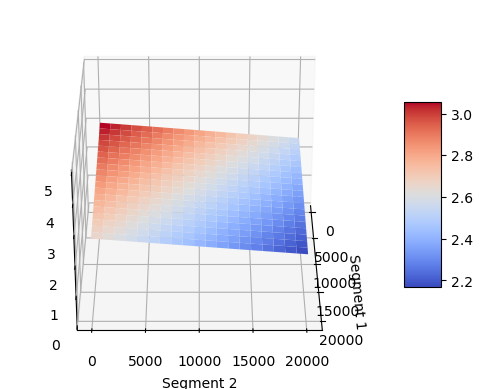

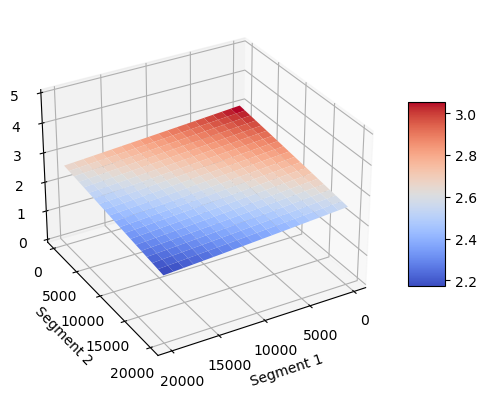

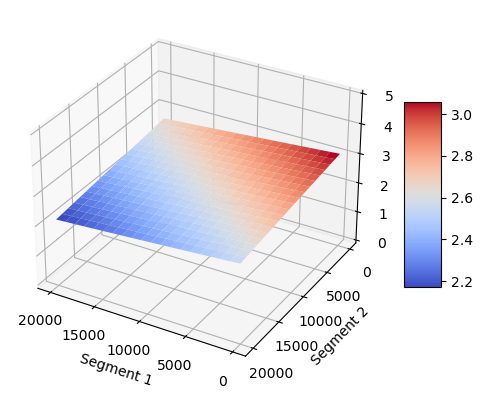

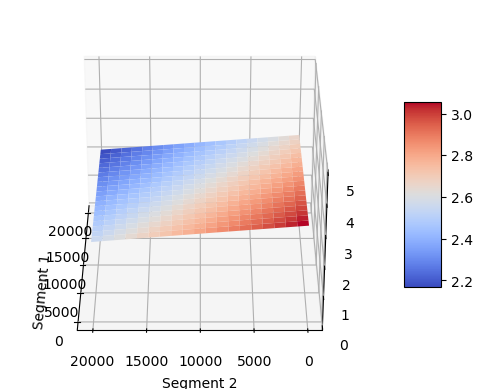

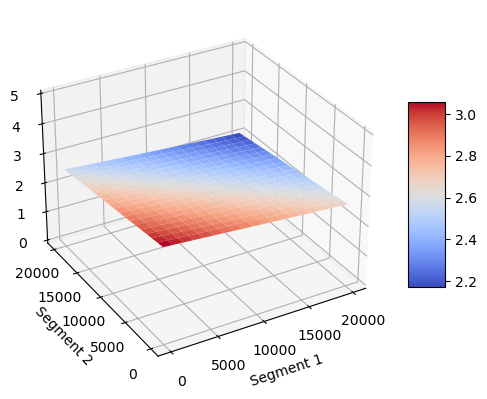

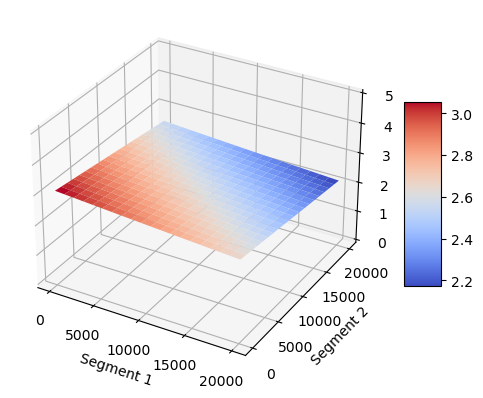

In [169]:
# visualize value of waiting on segment 1 and segemet 2
V1_test = pricing_model.solve_vfi(V0_wait = [np.zeros((20,20,20)),np.zeros((20,20,20))],price0 = A/57)

x = pricing_model.Mgrid
y = pricing_model.Mgrid
X, Y = np.meshgrid(x, y)
Z = np.mean(V1_test[0] ,axis=0)

for angle in range(0, 360, 60):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlim(0, 5)

    surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.view_init(30, angle)
    ax.set_xlabel('Segment 1')
    ax.set_ylabel('Segment 2')

    plt.show()

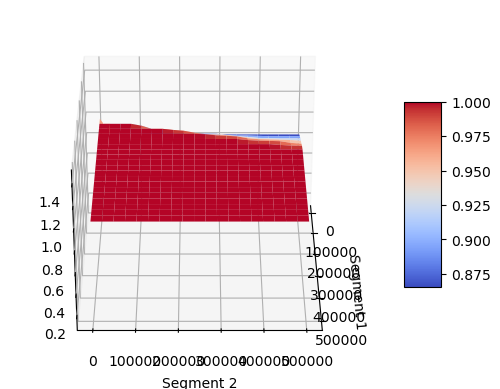

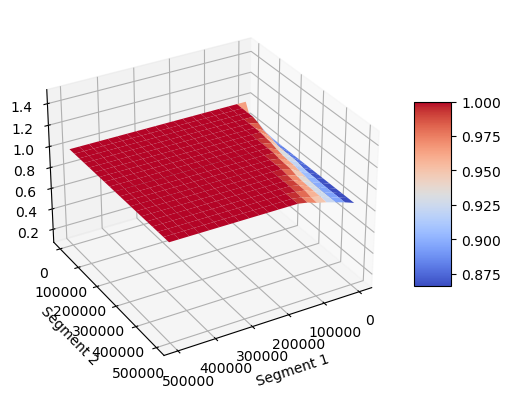

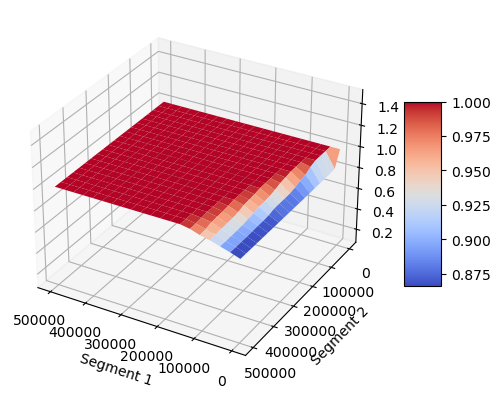

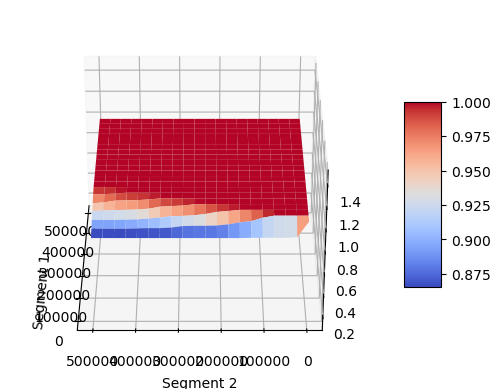

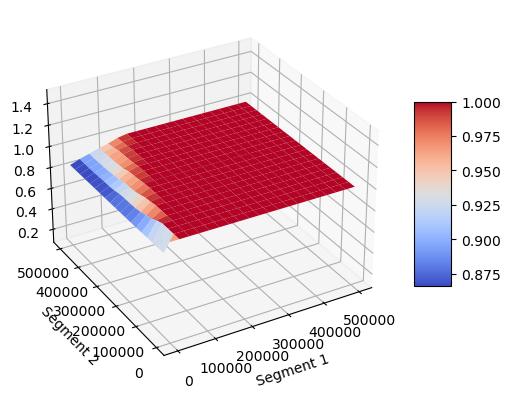

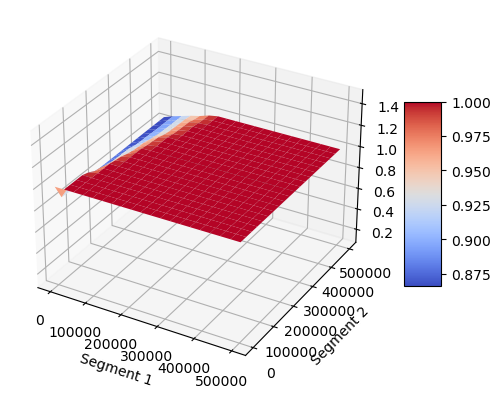

In [4]:
# visualize optimum policy on segment 1 and segment 2
x = pricing_model.Mgrid
y = pricing_model.Mgrid
X, Y = np.meshgrid(x, y)
Z = np.mean(price_policy,axis=0)

for angle in range(0, 360, 60):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlim(0.1, 1.5)
    surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.view_init(30, angle)
    ax.set_xlabel('Segment 1')
    ax.set_ylabel('Segment 2')

    plt.show()

## 消費者モデル

In [32]:
class DurableGoodsAdoptionModel:

    def __init__(self, ngrid=30, n_min=0.1, n_max=1, nquad=8, rho=[0.003, 0.98],
                 cov=[0.001, 0.0001, 0.0001, 0.001], beta=2, alpha=-4, delta=0.99):
        self.ngrid = ngrid
        self.grid = np.linspace(n_min, n_max, ngrid)
        self.nquad = nquad
        self.rho = np.array(rho)
        self.cov = np.array(cov).reshape(2, 2)
        self.beta = beta
        self.alpha = alpha
        self.delta = delta
        self.quadrature_setup()

    def quadrature_setup(self):
        node, weight = np.polynomial.hermite.hermgauss(self.nquad)
        chol_matrix = np.linalg.cholesky(self.cov) 
        self.node_psi, self.node_xi = np.sqrt(2) * chol_matrix @ np.vstack((node, node))
        # node_phi , node_xi is array([node_1,...,node_nquad])
        node_psi_xi = np.array(list(product(self.node_psi, self.node_xi))).T
        # 2 by nquad**2  array. All possible combination of node_psi and node_xi 
        weight_psi_xi = np.array(list(product(weight / np.sqrt(np.pi), weight / np.sqrt(np.pi)))).T
        # 2 by nquad**2 array. All possible combination of different weights 
        self.node_psi, self.node_xi = node_psi_xi[0], node_psi_xi[1]
        # each node is nquad**2 by 1 array
        self.weight_psi, self.weight_xi = weight_psi_xi[0], weight_psi_xi[1]
        # each weight is nquad**2 by 1 array

    def interp_func(self, x, f):
        """
        x is state gird.
        f is f(x) to be interpolated.

        """
        return interpolate.interp1d(x, f, kind='slinear', fill_value="extrapolate")

    def next_period_price(self, current_price):
        current_price = current_price[:, np.newaxis]
        next_price = self.rho[0] + self.rho[1] * current_price + self.node_psi
        return next_price

    def bellman(self, V0):
        """
        V0 is assumed to be 1 by ngrid array
        """
        next_price = self.next_period_price(current_price=self.grid)
        inter = self.interp_func(self.grid, V0)
        V0 = inter(next_price)
        V_purchase = self.beta + self.alpha * next_price + self.node_xi
        M = np.maximum(V0, V_purchase)
        try:
            new_V0 = self.delta * (M + np.log(np.exp(V0 - M) + np.exp(V_purchase - M))) @ (self.weight_psi * self.weight_xi).T
        except RuntimeWarning:
            print("Overflow error occurred! in new_V0")
        return new_V0

    def solve_vfi(self, maxiter=1000000, tol=1e-14):
        '''Solves the model using value function iterations (successive approximations of Bellman operator)
           Callback function is invoked at each iteration with keyword arguments.
        '''
        V0 = np.zeros(self.ngrid)
        for _ in range(maxiter):
            V1 = self.bellman(V0)
            err = np.amax(np.abs(V1 - V0))
            if err < tol:
                break
            V0 = V1
        else:
            print(f"V1:{V1}")
            print(f"err:{err}")
            raise RuntimeError('No convergence: maximum number of iterations achieved!')
        return V1


## データシミュレーション

In [33]:
def simulate_price_process(T=30, price_0=50, model=None, seed=1234):
    np.random.seed(seed)
    mean = np.array([0, 0])

    shocks = np.random.multivariate_normal(mean, model.cov, size=T)
    psi, xi = shocks[:, 0], shocks[:, 1]

    price = np.zeros(T)
    price[0] = np.array(price_0)
    for t in range(1, T):
        price[t] = model.rho[0] + model.rho[1] * price[t - 1] + psi[t]

    return price, xi, psi

In [34]:
model = DurableGoodsAdoptionModel()
model1 = DurableGoodsAdoptionModel(beta=2, alpha=-4)
model2 = DurableGoodsAdoptionModel(beta=5, alpha=-1)


def simulate_share(T=30, M=50, price_0=0.8, model1=model1, model2=model2, price_model=model, lambda1=0.7, seed=1234):
    lambda2 = 1 - lambda1
    init_M_type1 = int(round(M * lambda1, 0))
    init_M_type2 = int(round(M * lambda2, 0))

    beta_type1, alpha_type1 = model1.beta, model1.alpha
    beta_type2, alpha_type2 = model2.beta, model2.alpha

    price, xi, _ = simulate_price_process(T, price_0=price_0, model=price_model, seed=seed)

    V_type1 = model1.solve_vfi()
    V_type2 = model2.solve_vfi()

    inter_type1 = model1.interp_func(model1.grid, V_type1)
    inter_type2 = model2.interp_func(model2.grid, V_type2)

    v0_type1 = inter_type1(price)
    v0_type2 = inter_type2(price)

    share_type1, share_type2 = np.empty(T), np.empty(T)
    outside_share_type1, outside_share_type2 = np.empty(T), np.empty(T)
    sales_type1, sales_type2 = np.empty(T), np.empty(T)
    outside_sales_type1, outside_sales_type2 = np.empty(T), np.empty(T)
    share, outside_share = np.empty(T), np.empty(T)
    sales, outside_sales = np.empty(T), np.empty(T)
    M_type1, M_type2 = np.empty(T), np.empty(T)

    M_type1_t, M_type2_t = 1, 1
    for t in range(T):
        if np.any(M_type1_t > 0) and np.any(M_type2 > 0):
            try:
                outside_share_type1_t = np.exp(v0_type1[t] - v0_type1[t]) / (
                        np.exp(v0_type1[t] - v0_type1[t]) + np.exp(beta_type1 + alpha_type1 * price[t] + xi[t] - v0_type1[t]))
                outside_share_type2_t = np.exp(v0_type2[t] - v0_type2[t]) / (
                        np.exp(v0_type2[t] - v0_type2[t]) + np.exp(beta_type2 + alpha_type2 * price[t] + xi[t] - v0_type2[t]))
            except RuntimeWarning:
                print(f"v_type1_wait:{v0_type1[t]}")
                print(f"v_type2_wait:{v0_type2[t]}")
                print(f"v_type1_purchase:{beta_type1 + alpha_type2 * price[t] + xi[t] - v0_type1[t]}")
                print(f"v_type2_purchase:{beta_type1 + alpha_type2 * price[t] + xi[t] - v0_type2[t]}")
                raise RuntimeError("Overflow error occurred in outside_share")
            share_type1_t = 1 - outside_share_type1_t
            share_type2_t = 1 - outside_share_type2_t
            if t == 0:
                sales_type1_t = share_type1_t * init_M_type1
                sales_type2_t = share_type2_t * init_M_type2
                outside_sales_type1_t = init_M_type1 - sales_type1_t
                outside_sales_type2_t = init_M_type2 - sales_type2_t
                M_type1[0], M_type2[0] = init_M_type1, init_M_type2
                M_type1_t, M_type2_t = outside_sales_type1_t, outside_sales_type2_t

                share_type1[t], share_type2[t] = share_type1_t, share_type2_t
                outside_share_type1[t], outside_share_type2[t] = outside_share_type1_t, outside_share_type2_t
                sales_type1[t], sales_type2[t] = sales_type1_t, sales_type2_t
                outside_sales_type1[t], outside_sales_type2[t] = outside_sales_type1_t, outside_sales_type2_t
                sales[t], outside_sales[t] = sales_type1_t + sales_type2_t, outside_sales_type1_t + outside_sales_type2_t
                share[t], outside_share[t] = (sales[t] / (sales[t] + outside_sales[t])), (
                            outside_sales[t] / (sales[t] + outside_sales[t]))
            else:
                M_type1[t], M_type2[t] = M_type1_t, M_type2_t
                sales_type1_t = share_type1_t * M_type1[t]
                sales_type2_t = share_type2_t * M_type2[t]
                outside_sales_type1_t = M_type1[t] - sales_type1_t
                outside_sales_type2_t = M_type2[t] - sales_type2_t
                M_type1_t, M_type2_t = outside_sales_type1_t, outside_sales_type2_t

                share_type1[t], share_type2[t] = share_type1_t, share_type2_t
                outside_share_type1[t], outside_share_type2[t] = outside_share_type1_t, outside_share_type2_t
                sales_type1[t], sales_type2[t] = sales_type1_t, sales_type2_t
                outside_sales_type1[t], outside_sales_type2[t] = outside_sales_type1_t, outside_sales_type2_t
                sales[t], outside_sales[t] = sales_type1_t + sales_type2_t, outside_sales_type1_t + outside_sales_type2_t
                share[t], outside_share[t] = (sales[t] / (sales[t] + outside_sales[t])), (
                            outside_sales[t] / (sales[t] + outside_sales[t]))
        else:
            print(f"M_type1_t:{M_type1_t},M_type2_t:{M_type2_t}")
            raise RuntimeError("M took nagtive vlaue.")

        M_type1 = M_type1.astype(int)
        M_type2 = M_type2.astype(int)

    lambda_type1 = M_type1 / (M_type1 + M_type2)
    lambda_type2 = M_type2 / (M_type1 + M_type2)

    data = pd.DataFrame(
        np.hstack((sales[:, np.newaxis], outside_sales[:, np.newaxis],
                   sales_type1[:, np.newaxis], outside_sales_type1[:, np.newaxis],
                   sales_type2[:, np.newaxis], outside_sales_type2[:, np.newaxis],
                   share[:, np.newaxis], outside_share[:, np.newaxis],
                   share_type1[:, np.newaxis], outside_share_type1[:, np.newaxis],
                   share_type2[:, np.newaxis], outside_share_type2[:, np.newaxis],
                   price[:,np.newaxis],lambda_type1[:,np.newaxis],lambda_type2[:,np.newaxis],
                   M_type1[:,np.newaxis],M_type2[:,np.newaxis])),
        columns=["sales", "outside_sales",
                 "sales_type1", "outside_sales_type1",
                 "sales_type2", "outside_sales_type2",
                 "share", "outside_share",
                 "share_type1", "outside_share_type1",
                 "share_type2", "outside_share_type2",
                 "price", "lambda_type1", "lambda_type2", "M_type1", "M_type2"])

    return data

# Example usage
lambda_type1 = 0.7
data = simulate_share(T=85, M=500000, price_0=1, model1=model1, model2=model2, price_model=model, lambda1=lambda_type1, seed=1234)

    # Display the resulting DataFrame
data

,sales,outside_sales,sales_type1,outside_sales_type1,sales_type2,outside_sales_type2,share,outside_share,share_type1,outside_share_type1,share_type2,outside_share_type2,price,lambda_type1,lambda_type2,M_type1,M_type2
0,10451.755334,489548.244666,2364.300044,347635.699956,8087.455290,141912.544710,0.020904,0.979096,0.006755,0.993245,0.053916,0.946084,1.000000,0.700000,0.300000,350000.0,150000.0
1,10362.080033,479184.919967,2629.948937,345005.051063,7732.131097,134179.868903,0.021167,0.978833,0.007565,0.992435,0.054485,0.945515,0.956032,0.710116,0.289884,347635.0,141912.0
2,10851.209503,468332.790497,2951.745455,342053.254545,7899.464048,126279.535952,0.022645,0.977355,0.008556,0.991444,0.058873,0.941127,0.937991,0.719984,0.280016,345005.0,134179.0
3,9910.234704,458421.765296,2896.548151,339156.451849,7013.686553,119265.313447,0.021161,0.978839,0.008468,0.991532,0.055541,0.944459,0.915575,0.730364,0.269636,342053.0,126279.0
4,9073.356593,449347.643407,2604.555261,336551.444739,6468.801332,112796.198668,0.019793,0.980207,0.007680,0.992320,0.054239,0.945761,0.947470,0.739835,0.260165,339156.0,119265.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,1886.636152,47734.363848,1838.634433,47083.365567,48.001719,650.998281,0.038021,0.961979,0.037583,0.962417,0.068672,0.931328,0.225866,0.985913,0.014087,48922.0,699.0
81,1765.757577,45967.242423,1720.757134,45362.242866,45.000443,604.999557,0.036992,0.963008,0.036547,0.963453,0.069231,0.930769,0.251294,0.986383,0.013617,47083.0,650.0
82,1721.390943,44244.609057,1678.279804,43683.720196,43.111138,560.888862,0.037449,0.962551,0.036997,0.963003,0.071376,0.928624,0.264635,0.986860,0.013140,45362.0,604.0
83,1658.343197,42584.656803,1619.448474,42063.551526,38.894723,521.105277,0.037483,0.962517,0.037073,0.962927,0.069455,0.930545,0.243640,0.987343,0.012657,43683.0,560.0


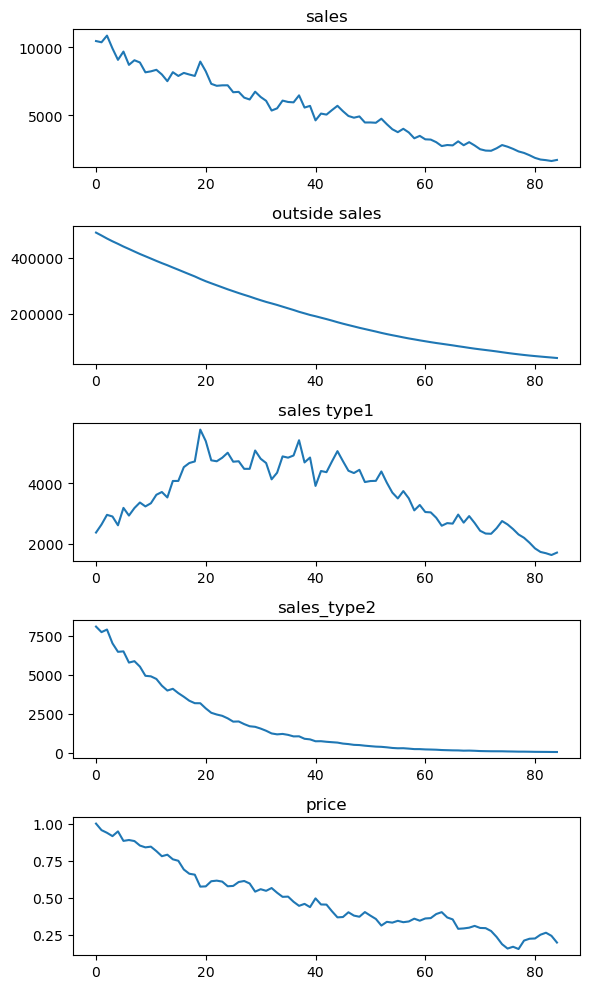

In [48]:
fig,axs = plt.subplots(5,1,figsize=(6,10))
axs[0].plot(data.sales)
axs[0].set_title("sales")
axs[1].plot(data.outside_sales)
axs[1].set_title("outside sales")
axs[2].plot(data.sales_type1)
axs[2].set_title("sales type1")
axs[3].plot(data.sales_type2)
axs[3].set_title("sales_type2")
axs[4].plot(data.price)
axs[4].set_title("price")
plt.tight_layout()
plt.show()

## 最適価格政策の下でのシミュレーション
$\xi$はランダムな需要ショックなので、複数の異なるseed値により$\xi$生成し、それに対して価格最適化のシミュレーションを行う。初期価格はあらかじめ決める必要があるためシミュレーションデータと同じ1と設定する。

In [45]:
sigma_xi = model1.cov[1,1]
v0_type1 = model1.solve_vfi()
v0_type2 = model2.solve_vfi()
I = 100 # the number of simulation
T = 85 # the number of period
simulations = {}
initial_M = data.sales[0]+data.outside_sales[0]
price_policy = price_policy
initial_price = 1
for i in range(I):
    np.random.seed(i)
    xi = np.random.normal(0,sigma_xi,(T,1))
    sales_type1,sales_type2,price,M_type1,M_type2 = np.empty(T),np.empty(T),np.empty(T),np.empty(T),np.empty(T)
    for t in range(T):
        if t == 0:
                v0_type1_t = model1.interp_func(model1.grid, v0_type1)(initial_price)
                v0_type2_t = model2.interp_func(model2.grid, v0_type2)(initial_price)
                outside_share_type1_t = (np.exp(v0_type1_t-v0_type1_t)/(np.exp(v0_type1_t-v0_type1_t)+np.exp(model1.beta+model1.alpha*initial_price+xi[t]-v0_type1_t)))
                outside_share_type2_t = (np.exp(v0_type2_t-v0_type2_t)/(np.exp(v0_type2_t-v0_type2_t)+np.exp(model2.beta+model2.alpha*initial_price+xi[t]-v0_type2_t)))
                sales_type1_t = lambda_type1*initial_M*(1-outside_share_type1_t)
                sales_type2_t = (1-lambda_type1)*initial_M*(1-outside_share_type2_t)
                nextM_type1 = lambda_type1*initial_M*outside_share_type1_t
                nextM_type2 = (1-lambda_type1)*initial_M*outside_share_type2_t
                next_price = pricing_model.interpolate_V0(price_policy,xi[t],lambda_type1*initial_M,(1-lambda_type1)*initial_M)
                next_price = np.where(next_price < 0, 0.1, next_price)

                sales_type1[t] = sales_type1_t
                sales_type2[t] = sales_type2_t
                price[t] = initial_price
                price[t+1] = next_price
                M_type1[t] = lambda_type1*initial_M
                M_type2[t] = (1-lambda_type1)*initial_M
                M_type1[t+1] = nextM_type1
                M_type2[t+1] = nextM_type2
        elif t == T-1:
                v0_type1_t = model1.interp_func(model1.grid, v0_type1)(price[t])
                v0_type2_t = model2.interp_func(model2.grid, v0_type2)(price[t])
                outside_share_type1_t = (np.exp(v0_type1_t-v0_type1_t)/(np.exp(v0_type1_t-v0_type1_t)+np.exp(model1.beta+model1.alpha*price[t]+xi[t]-v0_type1_t)))
                outside_share_type2_t = (np.exp(v0_type2_t-v0_type2_t)/(np.exp(v0_type2_t-v0_type2_t)+np.exp(model2.beta+model2.alpha*price[t]+xi[t]-v0_type2_t)))
                sales_type1_t = M_type1[t]*(1-outside_share_type1_t)
                sales_type2_t = M_type2[t]*(1-outside_share_type2_t)
                sales_type1[t] = sales_type1_t
                sales_type2[t] = sales_type2_t
        else:
                v0_type1_t = model1.interp_func(model1.grid, v0_type1)(price[t])
                v0_type2_t = model2.interp_func(model2.grid, v0_type2)(price[t])
                outside_share_type1_t = (np.exp(v0_type1_t-v0_type1_t)/(np.exp(v0_type1_t-v0_type1_t)+np.exp(model1.beta+model1.alpha*price[t]+xi[t]-v0_type1_t)))
                outside_share_type2_t = (np.exp(v0_type2_t-v0_type2_t)/(np.exp(v0_type2_t-v0_type2_t)+np.exp(model2.beta+model2.alpha*price[t]+xi[t]-v0_type2_t)))
                sales_type1_t = M_type1[t]*(1-outside_share_type1_t)
                sales_type2_t = M_type2[t]*(1-outside_share_type2_t)
                nextM_type1 = M_type1[t]*outside_share_type1_t
                nextM_type2 = M_type2[t]*outside_share_type2_t
                next_price = pricing_model.interpolate_V0(price_policy,xi[t],M_type1[t],M_type2[t])
                next_price = np.where(next_price < 0, 0.1, next_price)

                sales_type1[t] = sales_type1_t
                sales_type2[t] = sales_type2_t
                price[t+1] = next_price
                M_type1[t+1] = nextM_type1
                M_type2[t+1] = nextM_type2
    simulated_data = pd.DataFrame({"sales_type1":sales_type1,"sales_type2":sales_type2,"price":price,"M_type1":M_type1,"M_type2":M_type2})
    simulations[i] = simulated_data

C:\Users\haruto\AppData\Local\Temp\ipykernel_25264\264655826.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sales_type1[t] = sales_type1_t
C:\Users\haruto\AppData\Local\Temp\ipykernel_25264\264655826.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sales_type2[t] = sales_type2_t
C:\Users\haruto\AppData\Local\Temp\ipykernel_25264\264655826.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  price[t+1] = next_price
C:\Users\haruto\AppData\Local\Temp\ipyker

## 最適価格の下での利益とシミュレーションデータの利益
最適価格の下では約10万の利益向上が確認できる。

In [46]:
profit = np.empty(I)
for i in range(I):
    profit[i] = np.sum(simulations[i].price*(simulations[i].sales_type1+simulations[i].sales_type2)-pricing_model.c*(simulations[i].sales_type1+simulations[i].sales_type2))
print(f"Optimum profit max:{max(profit)}")
print(f"Optimum profit average:{np.average(profit)}")
print(f"Optimum profit min:{min(profit)}")
print(f"Actual profit in data:{np.sum(data.price*(data.sales)-pricing_model.c*(data.sales))}")

Optimum profit max:141406.48095790035
Optimum profit average:141394.89161201
Optimum profit min:141381.5670338324
Actual profit in data:40019.181596849245


最適価格に対して需要がどのように変化したかを確認すると、最適価格は実際の価格よりも高めに価格を設定することで利益を増やしたことが分かる。そのため消費者タイプ１の売上（需要）が実際のデータよりも少なくなっている。

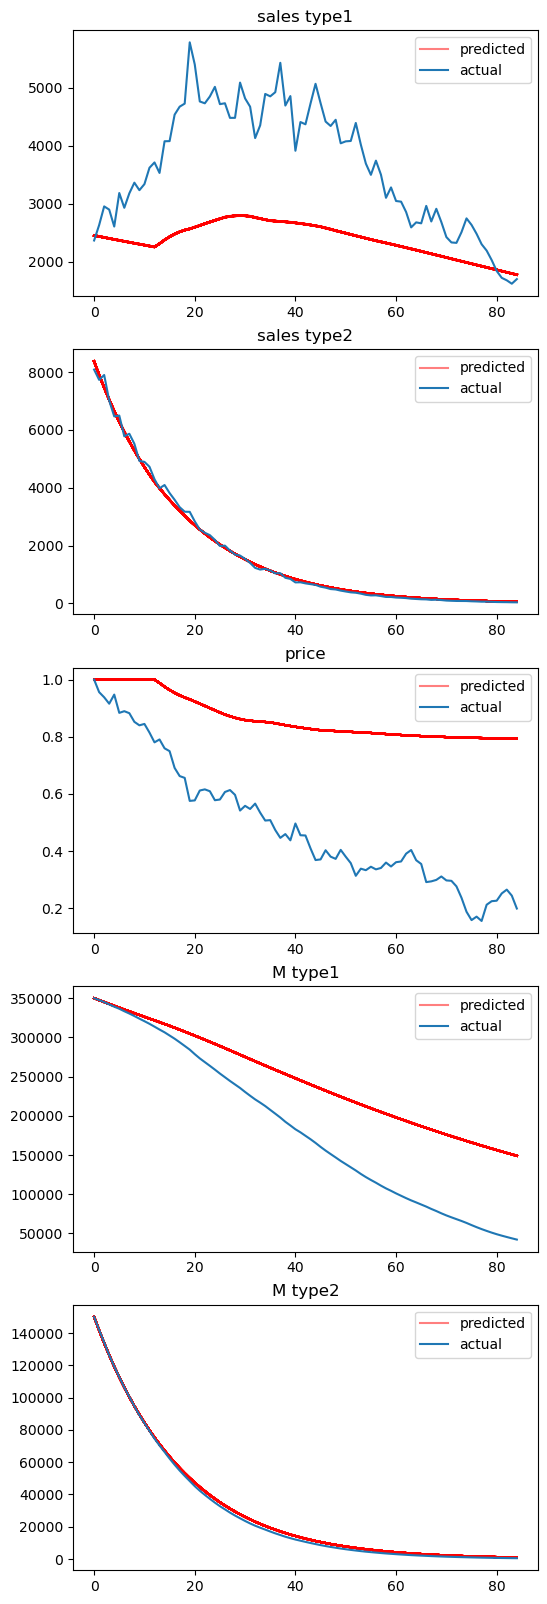

In [47]:
fig,axs = plt.subplots(5,1,figsize=(6,20))
for i in range(I):
    label = "predicted" if i == I-1 else None  # 最後のイテレーション時にのみラベルを"predicted"に設定
    axs[0].plot(simulations[i].sales_type1,alpha=0.5,color="red",label=label)   
    axs[0].set_title("sales type1")   
    axs[1].plot(simulations[i].sales_type2,alpha=0.5,color="red", label=label)
    axs[1].set_title("sales type2")
    axs[2].plot(simulations[i].price,alpha=0.5,color="red", label=label)
    axs[2].set_title("price")
    axs[3].plot(simulations[i].M_type1,alpha=0.5,color="red", label=label)    
    axs[3].set_title("M type1")
    axs[4].plot(simulations[i].M_type2,alpha=0.5,color="red", label=label)
    axs[4].set_title("M type2")
axs[0].plot(data.sales_type1,label="actual")
axs[0].legend()
axs[1].plot(data.sales_type2,label="actual")
axs[1].legend()
axs[2].plot(data.price,label="actual")
axs[2].legend()
axs[3].plot(data.M_type1,label="actual")
axs[3].legend()
axs[4].plot(data.M_type2,label="actual")
axs[4].legend()
plt.show()